Hva du faktisk kan analysere (konkrete forslag så du slipper å gjette)

Her er tre analyser som er enkle, ser avanserte ut og gir mening:

1. Hvor forskjellige er veinettverkene mellom to bydeler?

Indikatorer:

Gatetetthet (km/km²)

Node degree (hvor mange T-kryss vs 4-vei-kryss)

Betweenness centrality for veier

Closeness centrality for kryss

Hvorfor det funker:

Det er visuelt

Det er lett å forklare

Det gir et fint narrativ: «Bydel X har mer integrert veinett enn bydel Y»

2. Finn de viktigste veiene i en bydel (basert på betweenness)

Dette høres ekstremt smart ut på papiret og ser bra ut på et kart.

Vis f.eks:

Veier farget etter betweenness-verdi

Top 10 viktigste veier listet opp

Dette krever basically tre linjer med osmnx.

3. Hvor kronglete er veinettet?

Bruk:

Circuity = faktisk avstand / luftlinje

Dette er genialt hvis du sammenligner:

En «rutenett»-bydel (Frogner-ish)

En «organisk/forbannet labyrint»-bydel (Stovner-ish)

Resultatet blir automatisk interessant.

En veldig enkel prosjektidé for deg

Hvis du vil ha noe knallenkelt som likevel ser kult ut, så gjør følgende:

Tema:
Urbane indikatorer: sammenligning av gatenettverksstruktur mellom Stovner og Frogner.

Forskningsspørsmål:

Hvilken bydel har størst gatetetthet?

Hvilken bydel har mest integrert veinett?

Hvilke veier fungerer som hovedårer i hver bydel?

Hvor kronglete er veinettet i de to bydelene?

Datasett:

Introduksjon

Inkluder oppsett: 

Datainnhenting

Gatetetthet

Node degree



In [128]:
# importerer nødvendige bibliotek:

import contextily as ctx
import geopandas as gpd #fjern denne, for test kode


import osmnx as ox
from importlib import reload
import funksjoner
import matplotlib.pyplot as plt


Datainnhenting

In [129]:


# Her kan du oppdatere ordboken med områdene du ønsker å analysere
# Den følger (Nomatim) format Key = Navn, Value = bydel/område, by/kommune, land"

OMRÅDER = {
    "Stovner" : "Stovner, Oslo, Norway",
    "Frogner" : "Frogner, Oslo, Norway"
}

In [130]:
# Henter graph over områdene, med bilvei som standard nettverkstype:
grafer, nodes, edges = funksjoner.bygg_graf(OMRÅDER)

Henter data for Stovner, Oslo, Norway ...
Innehneting av data for Stovner, Oslo, Norway velykket!
Henter data for Frogner, Oslo, Norway ...
Innehneting av data for Frogner, Oslo, Norway velykket!


In [131]:
# Henter ut polygonene for området for videre analyse:
# denne funksjonen returnerer EPSG:25833 som crs dersom ikke noe annet sendes inn i funksjonen

polygoner = funksjoner.sted_til_poly(OMRÅDER)

# Polygoner er en dict på formen polygoner["stedsnavn"]["geometry"]
# Der stedsnavn er et navn fra OMRÅDER definert ovenfor


Beregning av gatetetthet

Nå har vi polygonet for stovner og frogner i en dictionary, samt tilhørende grafer.
Nå bruker vi street_length_total() fra omnx for å finne total veilengde.
Deretter deles dette på totalt areal for området. Resultat: veilengde per km^2

In [132]:
resultater = funksjoner.beregn_gatetetthet(grafer, polygoner)

Funksjonen gir resultatet som en nøsted dictionary på formen:

gatetetthet = { 
    "Stovner": {
        "veilengde": ...,
        "polygon": ...,
        "areal": ...,
        "gatetetthet": ...
    },
    "Frogner": {
        "veilengde": ...,
        "polygon": ...,
        ...
    }
}


Nå har vi gatetetthet for de valgte områdene.
Resultatene kan visualiseres i et plot.

Gatetetthet (km/km²) for de to områdene:

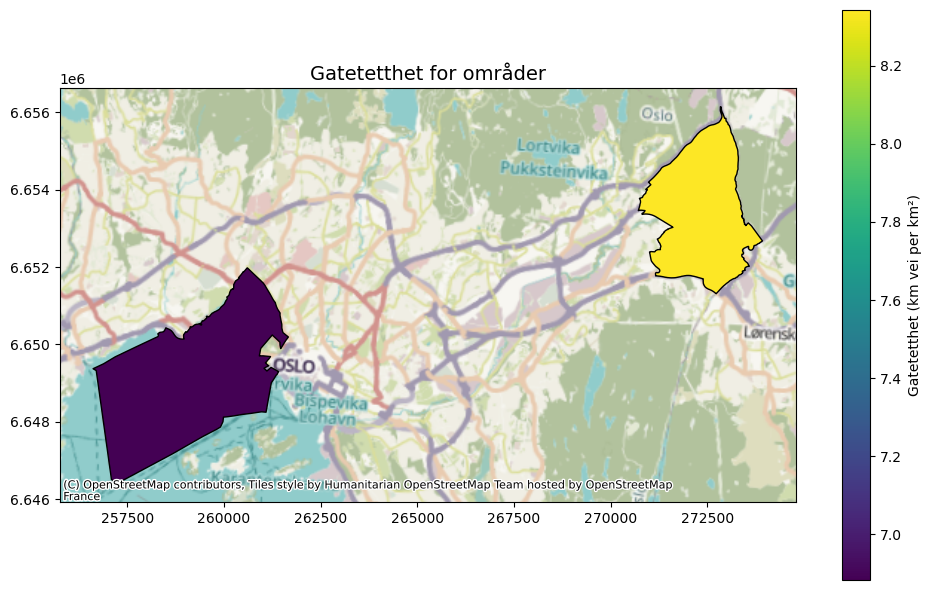

In [133]:
funksjoner.plot_gatetetthet(resultater)

__Dataanalyse__

Node degree 

Hyppighet av T-kryss vs 4-vei-kryss

Hvor finmasket veinettet er

Hvordan det henger sammen med gatetetthet

Node degree beskriver hvor mange veisegmenter som møtes i et kryss.
Lav degree (1–2) representerer blindveier og gjennomgående strekninger, mens høy degree (3–4+) representerer mer komplekse kryss.
Høyere grad betyr typisk at veinettet er mer sammenkoblet og “grid-aktig”.
Analysen viser at Frogner har langt flere høy-degree noder enn Stovner, noe som indikerer et mer finmasket og strukturert gatenettverk.

In [138]:
reload(funksjoner)

<module 'funksjoner' from 'c:\\Users\\hakon\\OneDrive - Norwegian University of Life Sciences\\Documents\\NMBU\\GMGI221 - automatiseringGIS\\ovinger\\Prosjekt\\funksjoner.py'>

In [139]:

# Beregner node degress
degrees_dict = funksjoner.beregn_degree(grafer)


In [ ]:
# Mapper degree inn i nodes geodataframen
# Her måtte jeg også ha litt hjelp av chatGPT

# så vidt jeg skjønner brukes node-IDene som nøkkel for å slå opp 
# degree-verdier som skrives inn i node-dataframen.
for navn in nodes:
    nodes[navn]["degree"] = nodes[navn].index.map(degrees_dict[navn])

Nå oppdaterer vi resultater dictionarien, slik at vi har en ryddige resultater for senere analyse:

In [ ]:
# Legger til degree mean og median i resultater
for navn in OMRÅDER.keys():
    resultater[navn]["degree_mean"] = nodes[navn]["degree"].mean()
    resultater[navn]["degree_median"] = nodes[navn]["degree"].median()

In [103]:
# For ordensskyld legges degree til som snitt og median,
# fint for evt analyse
for navn in OMRÅDER.keys():
    resultater[navn]["degree_snitt"] = nodes[navn]["degree"].mean()
    resultater[navn]["degree_median"] = nodes[navn]["degree"].median()

Beregne betweenness (viktigste veier)

Høy betweenness = “hovedåre”, “kritisk vei”, “hvis du stenger den kollapser trafikken”.
Lav betweenness = boliggate du ikke hadde merket om forsvant.

In [ ]:
betweenness = funksjoner.beregn_betweenness(grafer, edges)

Visualisering av resultater:

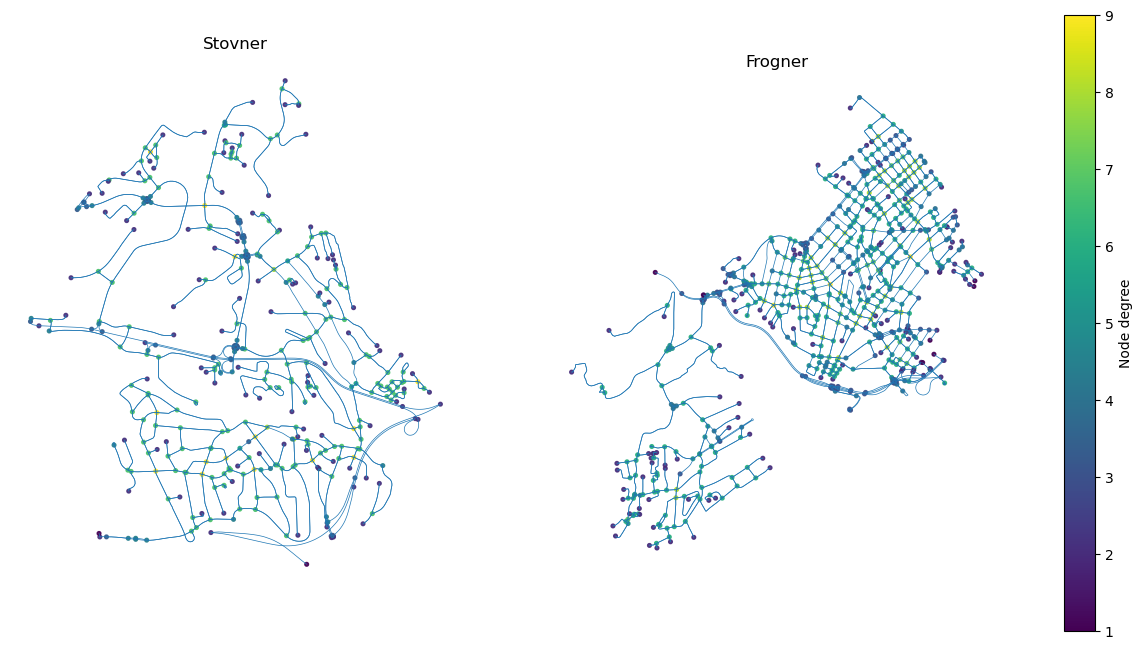

In [143]:

# For ikke å hardkode noe, henter jeg navnene gjennom .keys()
stedsnavn = list(OMRÅDER.keys())

fig, axes = plt.subplots(1, len(stedsnavn), figsize=(8*len(stedsnavn), 8))

# Her fikk jeg hjelp av ai for å plotte på en smart måte. Jeg ønsket et side by side plot,
# men var ikke sikkert på hvordan jeg kunne gjøre det uten å hardcode f. eks edges[stedsnavn[0]]["degree"]
# løsningen med løkke fikser dette, og er fleksibel med andre eller flere områder (selv om plottet kan bli rart
# med mange områder..)
for ax, navn in zip(axes, stedsnavn):
    # Plotter edges, veiene
    edges[navn].plot(ax=ax, linewidth=0.5)
    ax.set_title(navn)
    ax.set_axis_off()

    # plotter nodene degree, og farger etter verdi
    nodes[navn].plot(
    ax=ax,
    column="degree",
    cmap="viridis",
    markersize=7,
    alpha=0.9,
    legend=False
)
    
    sm = plt.cm.ScalarMappable(
    cmap="viridis",
    norm=plt.Normalize(
        vmin=min(nodes[navn]["degree"]),
        vmax=max(nodes[navn]["degree"])
    )
)
sm._A = []  # nødvendig hack for at Matplotlib ikke klikker
fig.colorbar(sm, ax=axes.ravel().tolist(), label="Node degree")


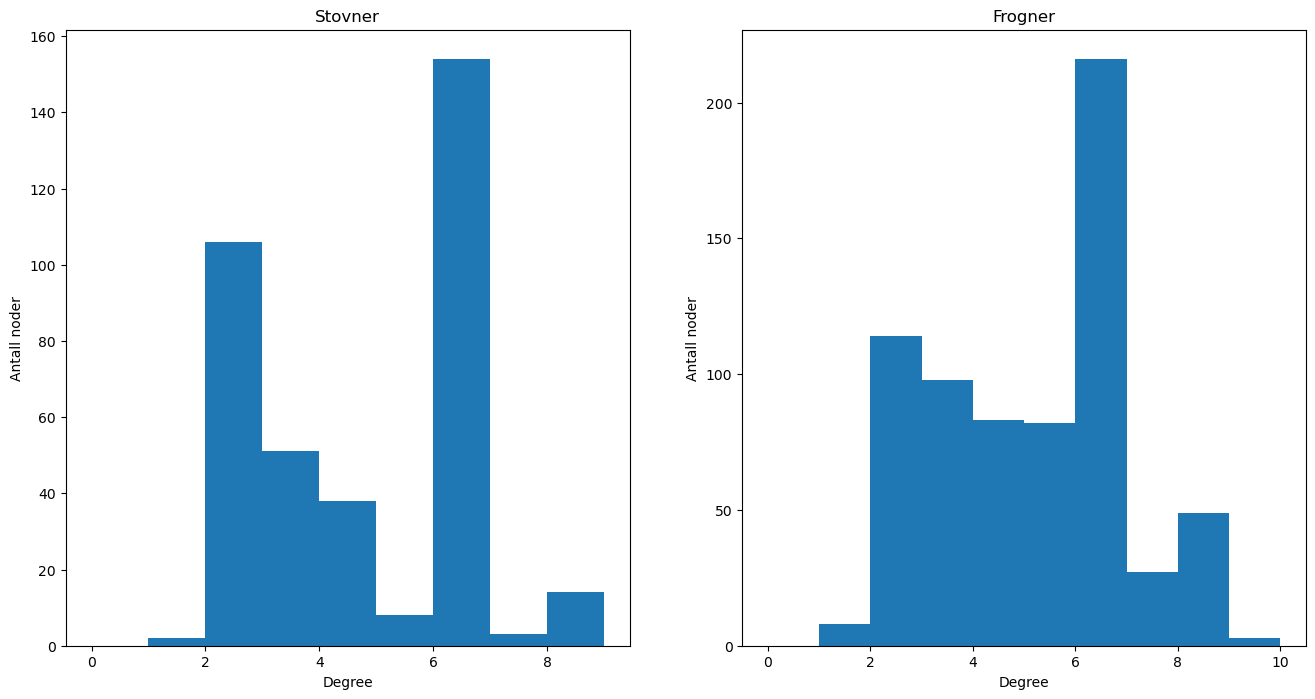

In [144]:
fig, axes = plt.subplots(1, len(stedsnavn), figsize=(8*len(stedsnavn), 8))

for ax, navn in zip(axes, stedsnavn):
    ax.hist(nodes[navn]["degree"], bins=range(0, nodes[navn]["degree"].max()+2))
    ax.set_title(navn)
    ax.set_xlabel("Degree")
    ax.set_ylabel("Antall noder")

